### Create New Variables
- Build many candidate variables for Project 2
- Include one risk table variable: likelihood of fraud for that day of the week. Don’t use the OOT data to calculate the risk table.
- Provide basic statistics for all candidate variables: Min, max, mean, stdev
- Submit an excel file with all candidate variables and statistics. This table will be # variables by 4 (max, min, mean, stdev)
- Also submit a word document with a high-level summary of the kinds of variables you created. Just a few bullet points. Include the total number of variables created.
- Probably have somewhere around 300 to 500 candidate variables
- The more the better. The more variety the better.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import numpy as np

df = pd.read_csv('applications data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   record       1000000 non-null  int64 
 1   date         1000000 non-null  int64 
 2   ssn          1000000 non-null  int64 
 3   firstname    1000000 non-null  object
 4   lastname     1000000 non-null  object
 5   address      1000000 non-null  object
 6   zip5         1000000 non-null  int64 
 7   dob          1000000 non-null  int64 
 8   homephone    1000000 non-null  int64 
 9   fraud_label  1000000 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 76.3+ MB


In [2]:
#fix datatype
df['date'] = pd.to_datetime(df.date.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))
df['zip5'] = df['zip5'].apply(lambda x: '{0:0>5}'.format(x))
df

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,19070626,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,2016-01-01,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0
...,...,...,...,...,...,...,...,...,...,...
999995,999996,2016-12-31,766104848,XUSAAURMZ,EJXXEXZX,8079 EJRUJ AVE,54890,19550418,8236558223,0
999996,999997,2016-12-31,445178058,SAAJJEMTX,UMAUETJX,4817 UMSXT AVE,74683,19150624,6790134432,0
999997,999998,2016-12-31,25283410,ESRXXRSUX,EUEJRJJE,7562 RJMAZ ST,86805,19880628,3997657622,0
999998,999999,2016-12-31,361232148,XXMZSRXMA,RSRSUJSS,3408 UZZAM WY,49183,20120302,5935293731,0


In [3]:
#fix frivolous values for ssn
df.loc[df.ssn==999999999,'ssn']= -df[df.ssn==999999999]['record']
df['ssn'] = df['ssn'].apply(lambda x : '{0:0>9}'.format(x))

In [4]:
#fix frivolous values for address
df.loc[df.address=='123 MAIN ST','address'] = df.loc[df.address=='123 MAIN ST','record'].\
    apply(lambda x: str(x)+' RECORD')

In [5]:
#fix frivolous values for dob
df.loc[df.dob==19070626,'dob']= -df.loc[df.dob==19070626]['record']
df['dob'] = df['dob'].apply(lambda x: '{0:0>8}'.format(x))

In [6]:
#fix frivolous values for homephone
df.loc[df.homephone == 9999999999,'homephone'] = -df.loc[df.homephone == 9999999999]['record']
df['homephone'] = df['homephone'].apply(lambda x: '{0:0>10}'.format(x))

In [7]:
#risk table for day of week
import calendar
df['dow'] = df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [8]:
train_test = df[df.date < '2016-11-01']

In [9]:
#statistical smoothing
c = 4
nmid = 20
y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg+(y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['dow_risk'] = df.dow.map(y_dow_smooth)

In [10]:
g = df.groupby('dow')['dow_risk'].mean()
plot = pd.DataFrame(g)
plot['order'] = [5,1,6,7,4,2,3]
plot = plot.sort_values('order')
plot

,dow_risk,order
dow,,
Monday,0.013480,1
Tuesday,0.014070,2
Wednesday,0.015169,3
Thursday,0.014981,4
Friday,0.014499,5
Saturday,0.014968,6
Sunday,0.013674,7


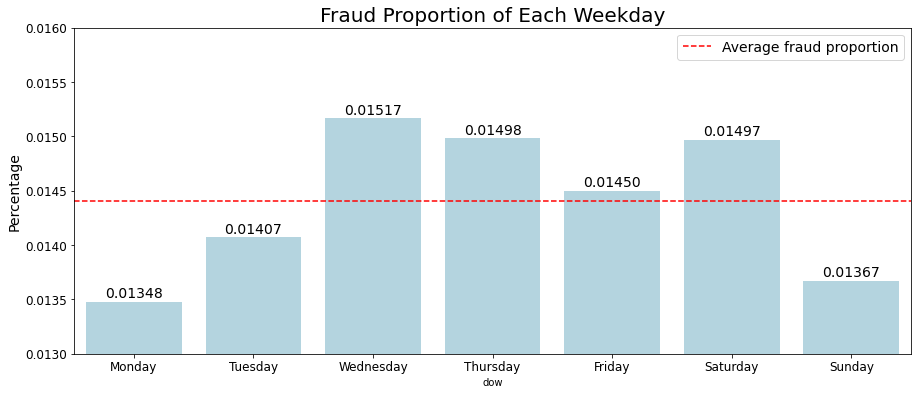

In [11]:
avg = sum(plot['dow_risk'])/7
plt.rc('legend',fontsize=14)
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
a = sns.barplot(x=plot.index,y='dow_risk',ax=ax,data=plot,color='lightblue',)
a.set_ylabel("Percentage",fontsize=14)
a.set_title('Fraud Proportion of Each Weekday', fontsize = 20)
a.tick_params(labelsize=12)
plt.axhline(y=avg, color='r', linestyle='--',label='Average fraud proportion')
plt.xticks(rotation=0)
a.set_ylim([0.013,0.016])

plt.legend()
for bar in a.patches:  
    a.annotate(format(bar.get_height(), '.5f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=14, xytext=(0, 8), 
                   textcoords='offset points') 
plt.show()

In [12]:
#create entities
df['name'] = df.firstname+df.lastname
df['fulladdress'] = df.address+df.zip5
df['name_dob'] = df.name + df.dob
df['name_fulladdress'] = df.name+df.fulladdress
df['name_homephone'] = df.name+df.homephone
df['fulladdress_dob'] = df.fulladdress+df.dob
df['fulladdress_homephone'] = df.fulladdress+df.homephone
df['dob_homephone'] = df.dob+df.homephone
df['homephone_name_dob'] = df.homephone+df.name_dob

In [13]:
for field in list(df.iloc[:,np.r_[3:9,12:15]].columns):
    df['ssn_'+ field] = df.ssn + df[field]

In [14]:
attributes = list(df.iloc[:,np.r_[2,5,7,8,12:30]].columns)

In [15]:
# velocity + day since
df1=df.copy()
final = df.copy()
df1['check_date'] = df1.date
df1['check_record'] = df1.record

In [16]:
start = time.time()
for entity in attributes:
    st = time.time()
    df_1 = df1[['record','date',entity]]
    df_r = df1[['check_record','check_date',entity]]
    temp = pd.merge(df_1, df_r, left_on = entity, right_on = entity)
    
    #day since
    day_since_df = temp[temp.record > temp.check_record][['record','date','check_date']].\
        groupby('record')[['date','check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    final[entity + '_day_since'] = final.record.map(mapper)
    final[entity + '_day_since'].fillna(365, inplace = True)
    print(f'\n{entity}_day_since ---> Done')
    
    #velocity
    for offset_t in [0,1,3,7,14,30]:
        count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t)))
                           & (temp.record >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        final[col_name] = final.record.map(mapper2)
        
        print(f'{entity}_count_{str(offset_t)} ---> Done')
    print(f'Run time for entity {entity} -------------- {time.time() - st:0.2f}s')
    
print(f'Total run time: {(time.time() - start) / 60:0.2f}min')


ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
Run time for entity ssn -------------- 3.62s

address_day_since ---> Done
address_count_0 ---> Done
address_count_1 ---> Done
address_count_3 ---> Done
address_count_7 ---> Done
address_count_14 ---> Done
address_count_30 ---> Done
Run time for entity address -------------- 3.56s

dob_day_since ---> Done
dob_count_0 ---> Done
dob_count_1 ---> Done
dob_count_3 ---> Done
dob_count_7 ---> Done
dob_count_14 ---> Done
dob_count_30 ---> Done
Run time for entity dob -------------- 26.98s

homephone_day_since ---> Done
homephone_count_0 ---> Done
homephone_count_1 ---> Done
homephone_count_3 ---> Done
homephone_count_7 ---> Done
homephone_count_14 ---> Done
homephone_count_30 ---> Done
Run time for entity homephone -------------- 20.98s

name_day_since ---> Done
name_count_0 ---> Done
name_count_1 ---> Done
name_count_3 ---> Done
name_co

In [17]:
#relative velocity
start = time.time()
for att in attributes:
    for d in ['0','1']:
        for dd in ['3','7','14','30']:
            final[att + '_count_' + d + '_by_' + dd] \
            = final[att + '_count_' + d] / (final[att+'_count_'+dd]/float(dd))
print(f'Total run time: {time.time() - start:0.2f}s')

Total run time: 5.23s


In [18]:
#unique value over past n days
attributes1 = ['ssn','name','dob','ssn_dob']
attributes2 = ['homephone', 'address','fulladdress']


start = time.time()
for entity1 in attributes1:
    for entity2 in attributes2:
        df_1 = df1[['record','date',entity1]]
        df_r = df1[['check_record','check_date',entity1,entity2]]
        temp = pd.merge(df_1, df_r,left_on=entity1,right_on=entity1)


        for offset_t in [0,1,3,7,14,30]:
            count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t)))
                               & (temp.record >= temp.check_record)]
            col_name = f'unique_{entity2}_of_{entity1}_{offset_t}'
            mapper2 = count_day_df.groupby('record')[entity2].nunique()
            final[col_name] = final.record.map(mapper2)

print(f'Total run time: {(time.time() - start) / 60:0.2f}min')

Total run time: 2.73min


In [19]:
# drop other variables except the ones created
for col in attributes:
    data = final.drop(col,1)

In [20]:
stats = data.describe().transpose()

In [21]:
stats = stats.drop(['count','25%','50%','75%'],1)

In [22]:
stats.to_excel('new variables.xlsx')

In [23]:
data.to_csv('full data.csv')

### Feature Filtering

- For all your candidate variables, calculate the univariate KS and univariate FDR at 3%.
- Sort the variables by both of these measures and provide the two rank ordered lists.
- Use only the data in the training/testing, that is, all records before 11/1.
- After creating the variables, probably best to leave out the first few weeks in January for feature selection since these variables aren’t all fully formed. (maybe leave out first 2 weeks)
- Add two test variables: a random variable and the fraud label. Should see near perfect performance for the fraud label “variable” and near zero predictability for the random variable.

In [24]:
from datetime import date, timedelta  
from scipy.stats import ks_2samp
from scipy import stats

In [25]:
fil = data.copy()

In [26]:
fil = fil[fil['date']<'2016-11-1']
time = fil.date.min()+timedelta(weeks=2)
fil = fil[fil['date']>=time]

In [27]:
# add a random column
length = len(fil)
x = np.random.normal(0, 1,length)
fil['random'] = x

In [28]:
KSFDR = pd.DataFrame(index = fil.columns)
KSFDR['KS']=np.nan
KSFDR['FDR']=np.nan

In [29]:
# Univariate KS
goods = fil[fil['fraud_label']==0]
bads = fil[fil['fraud_label']==1]

i = 0
for column in fil:
    KSFDR['KS'][i]= ks_2samp(goods[column],bads[column])[0]
    i=i+1

In [30]:
# univariate FDR @ 3%
j = 1
topRows = int(round(len(fil)*0.03))
numbads = sum(fil['fraud_label'])
for column in fil:
    temp = fil[[column,'fraud_label']].copy()
    if column == 'fraud_label':
        continue
    else:
        temp0 = temp.sort_values(column,ascending=False)
        temp1 = temp0.head(topRows)
        temp2 = temp0.tail(topRows)
        needed1 = temp1.loc[:,'fraud_label']
        needed2 = temp2.loc[:,'fraud_label']
        FDR1 = sum(needed1)/numbads
        FDR2 = sum(needed2)/numbads
        FDRate = np.maximum(FDR1,FDR2)
        KSFDR['FDR'][j] = FDRate
        j = j + 1
        
        
KSFDR.loc['fraud_label','FDR'] = 1
KSFDR = KSFDR.drop('record')

In [31]:
#sort by average rank
KSFDR['rank_ks'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)

In [32]:
ks = KSFDR.copy()
fdr = KSFDR.copy()

In [33]:
ks.sort_values(by=['rank_ks'], ascending=False, inplace=True)
fdr.sort_values(by=['rank_FDR'], ascending=False, inplace=True)

In [34]:
ks.reset_index(inplace = True)
ks = ks.rename(columns = {'index':'Variables'})
fdr.reset_index(inplace = True)
fdr = fdr.rename(columns = {'index':'Variables'})

In [35]:
final = pd.concat([ks,fdr],axis =1)
final.to_excel('filter1.xlsx')